In [22]:
#Libs to datamining and process
import pandas as pd
import numpy as np

In [55]:
#Libs to datascience and statistic
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, RepeatedStratifiedKFold,  train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

In [24]:
#Libs to Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets

In [25]:
train = pd.read_csv("data/loan_train.csv", delimiter= ",", encoding= "utf-8")
test = pd.read_csv("data/loan_test.csv", delimiter= ",", encoding= "utf-8")

In [27]:
def transform_data (df) : 
    
    df_aux = df.copy()
    
    #Tratativas colunas binárias
    df_aux['Married'] = np.where(df_aux['Married'] == 'Yes', 1, 0)
    df_aux['Male'] = np.where(df_aux['Gender'] == 'Male', 1, 0)
    df_aux['Graduate'] = np.where(df_aux['Education'] == 'Graduate', 1, 0)
    df_aux['Self_Employed'] = np.where(df_aux['Self_Employed'] == 'Yes', 1, 0)
    df_aux['Term_360'] = np.where(df_aux['Term'] == 360, 1, 0)
    df_aux['Credit_History'] = np.where(df_aux['Credit_History'] == 1, 1, 0)
    
    df_aux['Dependents'] = np.where(df_aux['Dependents'] == '3+', 3, df_aux['Dependents'])
    df_aux['Dependents'] = pd.to_numeric(df_aux['Dependents'], errors='coerce').fillna(df_aux['Dependents'].mode().iloc[0]).astype(int)
    
    # Criar colunas dummy a partir da coluna "Area"
    dummies = pd.get_dummies(df_aux['Area'], prefix='Area')
    df_aux = pd.concat([df_aux, dummies], axis=1)
    
    #Dropar colunas versao pré tratada
    df_aux = df_aux.drop(['Gender', 'Education', 'Term', 'Area'], axis=1)

    return df_aux

In [28]:
train_trat_v1 = transform_data(train)
train_trat_v1['Status'] = np.where(train_trat_v1['Status'] == 'Y', 0, 1)

test_trat_v1 = transform_data(test)

In [29]:
train_trat_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Married             614 non-null    int32  
 1   Dependents          614 non-null    int32  
 2   Self_Employed       614 non-null    int32  
 3   Applicant_Income    614 non-null    int64  
 4   Coapplicant_Income  614 non-null    float64
 5   Loan_Amount         614 non-null    int64  
 6   Credit_History      614 non-null    int32  
 7   Status              614 non-null    int32  
 8   Male                614 non-null    int32  
 9   Graduate            614 non-null    int32  
 10  Term_360            614 non-null    int32  
 11  Area_Rural          614 non-null    uint8  
 12  Area_Semiurban      614 non-null    uint8  
 13  Area_Urban          614 non-null    uint8  
dtypes: float64(1), int32(8), int64(2), uint8(3)
memory usage: 35.5 KB


In [30]:
train_trat_v1.describe()

,Married,Dependents,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Credit_History,Status,Male,Graduate,Term_360,Area_Rural,Area_Semiurban,Area_Urban
count,614.000000,614.000000,614.000000,6.140000e+02,6.140000e+02,6.140000e+02,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.648208,0.744300,0.133550,5.403459e+05,1.621246e+05,1.414104e+07,0.773616,0.312704,0.796417,0.781759,0.833876,0.291531,0.379479,0.328990
std,0.477919,1.009623,0.340446,6.109042e+05,2.926248e+05,8.815682e+06,0.418832,0.463973,0.402991,0.413389,0.372495,0.454838,0.485653,0.470229
min,0.000000,0.000000,0.000000,1.500000e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.877500e+05,0.000000e+00,9.800000e+06,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,3.812500e+05,1.188500e+05,1.250000e+07,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,5.795000e+05,2.297250e+05,1.647500e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,8.100000e+06,4.166700e+06,7.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Tratamento Outliers

In [31]:
def replace_outliers_with_median(column):
    # Calcula a mediana da coluna
    median = np.median(column)

    # Calcula o desvio padrão da coluna
    std = np.std(column)

    # Define um limite para identificar os outliers (2.5 vezes o desvio padrão)
    threshold = 2.5

    # Calcula o limite inferior
    lower_bound = median - threshold * std

    # Calcula o limite superior
    upper_bound = median + threshold * std

    # Substitui os valores abaixo do limite inferior pela mediana
    column.loc[column < lower_bound] = median

    # Substitui os valores acima do limite superior pela mediana
    column.loc[column > upper_bound] = median

In [32]:
colunas = ['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount']

# Substituir outliers pela mediana nas colunas selecionadas
for coluna in colunas:
    replace_outliers_with_median(train_trat_v1[coluna])

C:\Users\vitor\AppData\Local\Temp\ipykernel_1380\2744893341.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[column < lower_bound] = median
C:\Users\vitor\AppData\Local\Temp\ipykernel_1380\2744893341.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[column > upper_bound] = median


In [33]:
train_trat_v1.describe()

,Married,Dependents,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Credit_History,Status,Male,Graduate,Term_360,Area_Rural,Area_Semiurban,Area_Urban
count,614.000000,614.000000,614.000000,6.140000e+02,614.000000,6.140000e+02,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.648208,0.744300,0.133550,4.689531e+05,139578.570031,1.294528e+07,0.773616,0.312704,0.796417,0.781759,0.833876,0.291531,0.379479,0.328990
std,0.477919,1.009623,0.340446,3.006205e+05,164901.960661,5.909003e+06,0.418832,0.463973,0.402991,0.413389,0.372495,0.454838,0.485653,0.470229
min,0.000000,0.000000,0.000000,1.500000e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.877500e+05,0.000000,9.800000e+06,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,3.812250e+05,117775.000000,1.250000e+07,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,5.512750e+05,224550.000000,1.580000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,1.833300e+06,833300.000000,3.300000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Normalização Dados Numéricos

In [34]:
scaler = MinMaxScaler()

#Normalização dos dados caso necessario
train_trat_v1[['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount']] = scaler.fit_transform(train_trat_v1[['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount']])

# Logistic Regression Model

In [48]:
# Inicializar o modelo de regressão logística
model = LogisticRegression()

In [49]:
# Dividir os recursos e o alvo
X = train_trat_v1.drop('Status', axis=1)
y = train_trat_v1['Status']

## Curva ROC

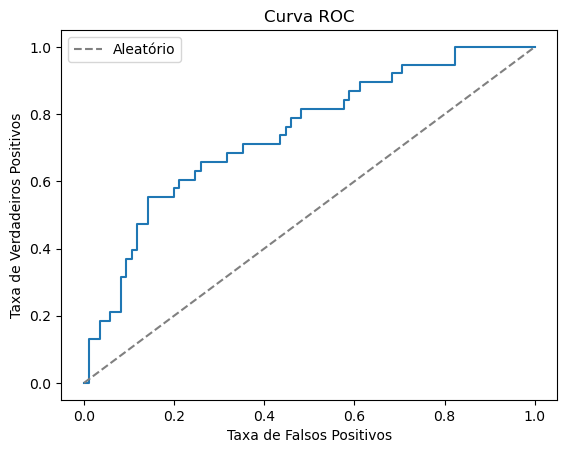

AUC-ROC: 0.7417956656346749

Tabela de Pontos de Corte (Fold 5):


Taxa de Falsos Positivos Taxa de Verdadeiros Positivos  \
                               mean                          mean   
Faixa                                                               
(0.0, 0.1]                     1.00                          1.00   
(0.1, 0.2]                     0.64                          0.88   
(0.2, 0.3]                     0.38                          0.71   
(0.3, 0.4]                     0.22                          0.59   
(0.4, 0.5]                      NaN                           NaN   
(0.5, 0.6]                     0.14                          0.55   
(0.6, 0.7]                     0.11                          0.39   
(0.7, 0.8]                     0.05                          0.18   
(0.8, 0.9]                     0.01                          0.00   
(0.9, 1.0]                      NaN                           NaN   

           Limiar (Threshold)        
                          max   min  
Faixa                                
(0.0, 0.1]               0.10  0.10  
(0.1, 0.2]               0.20  0.12  
(0.2, 0.3]               0.30  0.20  
(0.3, 0.4]               0.37  0.31  
(0.4, 0.5]                NaN   NaN  
(0.5, 0.6]               0.51  0.51  
(0.6, 0.7]               0.68  0.60  
(0.7, 0.8]               0.80  0.71  
(0.8, 0.9]               0.85  0.85  
(0.9, 1.0]                NaN   NaN

In [75]:
# Dividir em base de treino e teste mantendo a proporção de sucessos e fracassos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Inicializar o modelo de regressão logística
model = LogisticRegression()

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular as probabilidades das previsões
y_pred_proba = model.predict_proba(X_test)[:, 1]
# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Plotar a curva ROC
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Calcular a área sob a curva ROC (AUC-ROC)
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')
print()

#---------------------------------- Tabela de Threshold -----------------------------------
# Criar uma tabela para exibir os pontos de corte e os valores correspondentes
table_data = {'Taxa de Falsos Positivos': fpr,
              'Taxa de Verdadeiros Positivos': tpr,
              'Limiar (Threshold)': thresholds}
table_df = pd.DataFrame(table_data)

# Definir os limites das faixas de limiares
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Adicionar uma coluna 'Faixa' à tabela de pontos de corte
table_df['Faixa'] = pd.cut(table_df['Limiar (Threshold)'], bins)

# Agrupar os valores de fpr e tpr por faixa de limiar
grouped_table = table_df.groupby('Faixa').agg({'Taxa de Falsos Positivos': 'mean',  'Taxa de Verdadeiros Positivos': 'mean', 'Limiar (Threshold)' : ['max', 'min']})

# Exibir a tabela com os valores agrupados por faixa
print(f'Tabela de Pontos de Corte (Fold {fold}):')
grouped_table.round(2)

In [78]:
table_df

,Taxa de Falsos Positivos,Taxa de Verdadeiros Positivos,Limiar (Threshold),Faixa
0,0.000000,0.000000,1.850536,NaN
1,0.011765,0.000000,0.850536,"(0.8, 0.9]"
2,0.011765,0.131579,0.795225,"(0.7, 0.8]"
3,0.035294,0.131579,0.786627,"(0.7, 0.8]"
4,0.035294,0.184211,0.762525,"(0.7, 0.8]"
5,0.058824,0.184211,0.713662,"(0.7, 0.8]"
6,0.058824,0.210526,0.712283,"(0.7, 0.8]"
7,0.082353,0.210526,0.709734,"(0.7, 0.8]"
8,0.082353,0.315789,0.681502,"(0.6, 0.7]"
9,0.094118,0.315789,0.676940,"(0.6, 0.7]"


## Validação Cruzada 
     - Métricas : Accuracy, Precision, Recall, F1 e Matriz de Confusão

In [ ]:
# Inicializar o objeto de validação cruzada estratificada, para manter a propoção da variavel alvo entre os folds
#Em resumo, o StratifiedKFold é usado para realizar a divisão estratificada dos dados em k folds, enquanto o RepeatedStratifiedKFold estende essa funcionalidade para repetir esse processo de divisão várias vezes, fornecendo uma estimativa mais estável e confiável do desempenho do modelo.
stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

### Threshold 0.5

***********************Fold(1)**************************************

Acurácia fold(1): 0.75
Precisão fold(1): 0.67
Recall fold(1): 0.42
F1-Score fold(1): 0.51



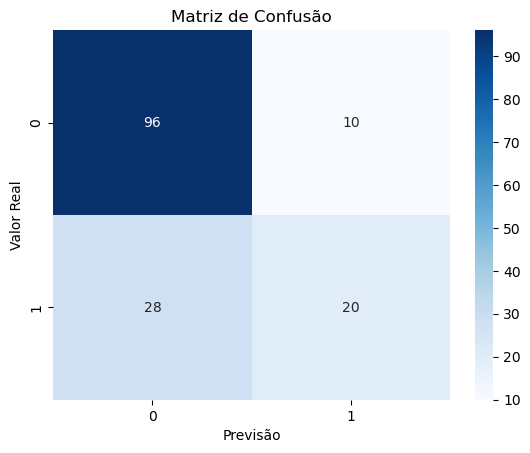


***********************Fold(2)**************************************

Acurácia fold(2): 0.75
Precisão fold(2): 0.67
Recall fold(2): 0.42
F1-Score fold(2): 0.51



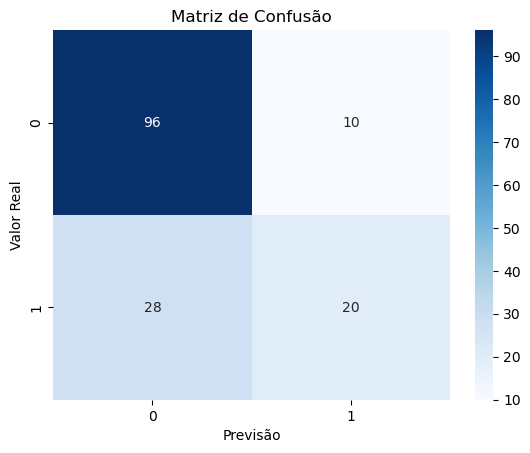


***********************Fold(3)**************************************

Acurácia fold(3): 0.78
Precisão fold(3): 0.71
Recall fold(3): 0.5
F1-Score fold(3): 0.59



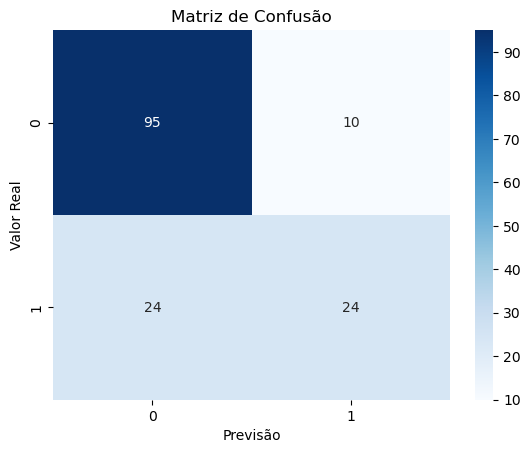


***********************Fold(4)**************************************

Acurácia fold(4): 0.77
Precisão fold(4): 0.7
Recall fold(4): 0.48
F1-Score fold(4): 0.57



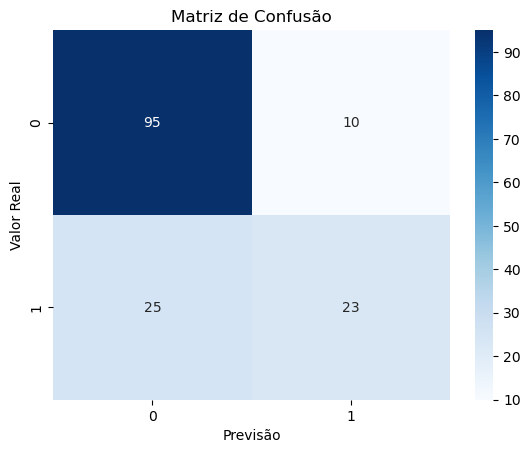

In [58]:
# Inicializar listas vazias para armazenar as métricas de avaliação
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

fold = 1
# Loop de validação cruzada
for train_index, test_index in stratified_kfold.split(X, y):
    
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inicializar o modelo de regressão logística
    model = LogisticRegression()
    
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)
        
    # Calcular as métricas de avaliação e adicioná-las às listas
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, zero_division=1))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=1))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=1))
    
    
    #**************************Representações por Fold************************************* :
    print(f'***********************Fold({fold})**************************************')
    print()
    print(f'Acurácia fold({fold}): {accuracy_score(y_test, y_pred).round(2)}')
    print(f'Precisão fold({fold}): {precision_score(y_test, y_pred, zero_division=1).round(2)}')
    print(f'Recall fold({fold}): {recall_score(y_test, y_pred, zero_division=1).round(2)}')
    print(f'F1-Score fold({fold}): {f1_score(y_test, y_pred, zero_division=1).round(2)}')
    print()
    # Calcular a matriz de confusão
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Plotar a matriz de confusão
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Previsão')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusão')
    plt.show()
    print()
    
    fold += 1

In [ ]:
# Imprimir as métricas de avaliação médias
print(f'Acurácia média: {np.mean(accuracy_scores).round(2)}')
print(f'Precisão média: {np.mean(precision_scores).round(2)}')
print(f'Recall médio: {np.mean(recall_scores).round(2)}')
print(f'F1-Score médio: {np.mean(f1_scores).round(2)}')

### Threshold 0.8

***********************Fold(1)**************************************

Acurácia fold(1): 0.7
Precisão fold(1): 1.0
Recall fold(1): 0.04
F1-Score fold(1): 0.08



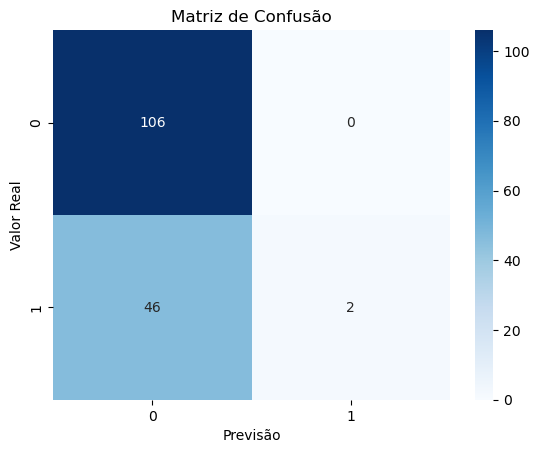


***********************Fold(2)**************************************

Acurácia fold(2): 0.7
Precisão fold(2): 0.67
Recall fold(2): 0.08
F1-Score fold(2): 0.15



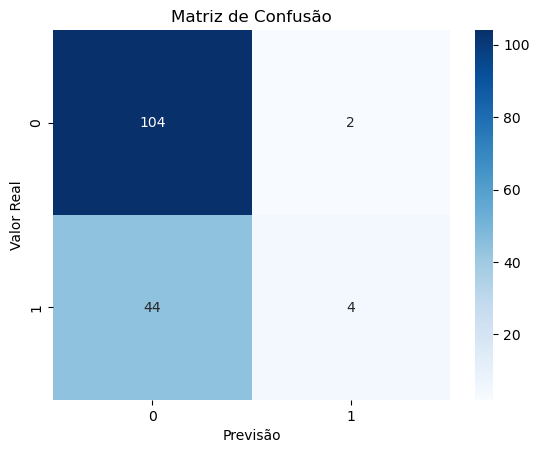


***********************Fold(3)**************************************

Acurácia fold(3): 0.7
Precisão fold(3): 0.67
Recall fold(3): 0.08
F1-Score fold(3): 0.15



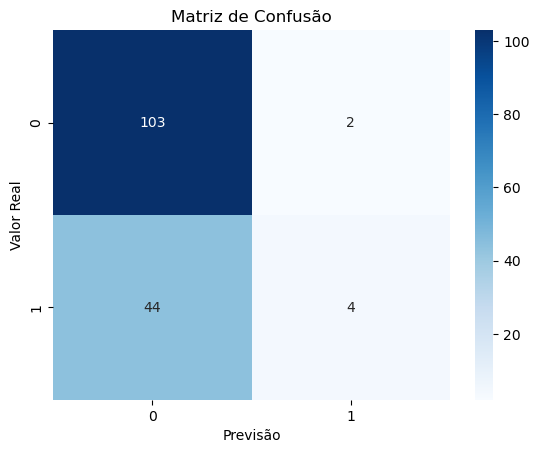


***********************Fold(4)**************************************

Acurácia fold(4): 0.69
Precisão fold(4): 1.0
Recall fold(4): 0.0
F1-Score fold(4): 0.0



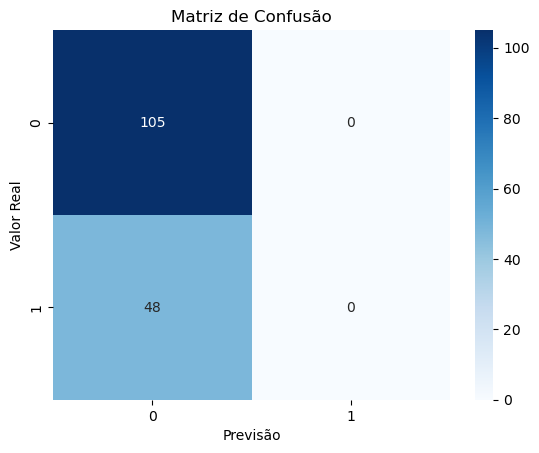

In [83]:
# Inicializar listas vazias para armazenar as métricas de avaliação
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

fold = 1
# Loop de validação cruzada
for train_index, test_index in stratified_kfold.split(X, y):
    
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inicializar o modelo de regressão logística
    model = LogisticRegression()
    
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Fazer previsões das probabilidades no conjunto de teste
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Aplicar o ponto de corte de 0.2 para atribuir as classes
    y_pred = (y_pred_proba >= 0.8).astype(int)
        
    # Calcular as métricas de avaliação e adicioná-las às listas
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, zero_division=1))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=1))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=1))
    
    
    #**************************Representações por Fold************************************* :
    print(f'***********************Fold({fold})**************************************')
    print()
    print(f'Acurácia fold({fold}): {accuracy_score(y_test, y_pred).round(2)}')
    print(f'Precisão fold({fold}): {precision_score(y_test, y_pred, zero_division=1).round(2)}')
    print(f'Recall fold({fold}): {recall_score(y_test, y_pred, zero_division=1).round(2)}')
    print(f'F1-Score fold({fold}): {f1_score(y_test, y_pred, zero_division=1).round(2)}')
    print()
    
    # Calcular a matriz de confusão
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Plotar a matriz de confusão
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Previsão')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusão')
    plt.show()
    print()
    
    fold += 1

In [81]:
# Imprimir as métricas de avaliação médias
print(f'Acurácia média: {np.mean(accuracy_scores).round(2)}')
print(f'Precisão média: {np.mean(precision_scores).round(2)}')
print(f'Recall médio: {np.mean(recall_scores).round(2)}')
print(f'F1-Score médio: {np.mean(f1_scores).round(2)}')

Acurácia média: 0.7
Precisão média: 0.83
Recall médio: 0.05
F1-Score médio: 0.09


# Conclusões v1 : Dados tratamento -> Remoção Outlier e Normalização dados numéricos
    - Modelo demonstra grande melhora